# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
date_str_start = '2014'
date_str_end = '2015'
fn_version = 'v0'
script_name = f"0.1_Rockall_Trough_moorings_ADCP_prep_{date_str_start}_{date_str_end}"

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# intput data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")
raw_data_path = Path('../data/raw')

# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = (global_data_path/ 'data_RT_mooring')
RTADCP_data_path = (RT_mooring_data_path/ 'RTADCP')
ERA5_data_path = (global_data_path/ 'data_ERA5/Rockall_Trough')

# file names
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_{date_str_start}_{date_str_end}_v0.nc'
RTADCP_fn = 'rtadcp1_01_2014_velocity_grid.mat'
RT_mooring_loc = 'Ellet_array_mooring_location.csv'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))
ERA5_fn = 'ERA5_tauxy_RT_2014-2022.nc' 

## Parameter Preamble

In [5]:
filter_length = 25     # (days)
corr_model = 0.0759    # Correction parameter (m/s) to adjust GLORYS DAC V component to the 8 month DAC from ADCP
z_cutoff_EW = 750     # Depth (m) where transition from GLORYS-ADCP data to CM data at Eastern wedge
z_cutoff_WW = 250     # Depth (m) limit of upper-left corner cutout
lon_cutoff_WW = -12.906  # Longitude limit of upper-left corner cutout
NX_WW = 100            # Horizontal grid size in Western wedge
NX_MB = 100           # Horizontal grid size in Mid-basin (needed for Ekman calc.)
NX_EW = 100            # Horizontal grid size in Eastern wedge
SA_ref = 35.34         # Reference Absolute Salinity (g/kg), for freshwater flux calc
CT_ref = 7.07          # Reference Conservative Temperature (C), for heat flux calc
rhoCp = 4.1e6         # Constant: Reference density times specific heat capacity (J m^-3 C^-1)   
rho0 = 1027            # Reference density          
Omega = 7.2921e-5     # Earth's rotation

## Load Data and prepare for calculations

In [6]:
# Rockall Trough mooring location
RT_loc = rtd.load_RT_loc(raw_data_path,RT_mooring_loc)

In [7]:
# gridded Rockall Trough ADCP data
ds_RTADCP = matlab_fct.load_RTADCP_mat(RTADCP_data_path,RTADCP_fn)
ds_RTADCP = ds_RTADCP.where(ds_RTADCP.vcur.isel(pres=0).notnull().drop_vars('pres'),drop=True)
ds_RTADCP.coords['depth'] = gsw.z_from_p(ds_RTADCP.pres,ds_RTADCP.lat.values)
ds_RTADCP = rtf.ds_rt_swap_vert_dim(ds_RTADCP,dim='pres')

In [8]:
# load GLORYS model data
ds_GLORYS_re = xr.open_mfdataset(GLORYS_fn_re)
ds_GLORYS_an = xr.open_mfdataset(GLORYS_fn_an)
ds_GLORYS_an.coords['latitude'] = ds_GLORYS_re.latitude # lat and lon slightly different values, i.e. manually merge
ds_GLORYS_an.coords['longitude'] = ds_GLORYS_re.longitude
ds_GLORYS_an.coords['depth'] = ds_GLORYS_re.depth
ds_GLORYS = xr.concat([ds_GLORYS_re,ds_GLORYS_an],'time')

v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=ds_RTADCP.lon.data,
                    latitude=ds_RTADCP.lat.data,
                    time=('time',ds_RTADCP.time.data),
                    depth=('depth',ds_RTADCP.depth.data)).squeeze()

# Duplicate top GLORYS-ADCP values
mask = ds_RTADCP.vcur.notnull()
# mask = (mask.notnull()+mask.shift(depth=-1).notnull())
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
v_GLO_RTADCP = v_GLO_RTADCP.where(mask).rename({'longitude':'lon'})
v_GLO_RTADCP.attrs['description']='GLORYS12v1 output at RTADCP location'

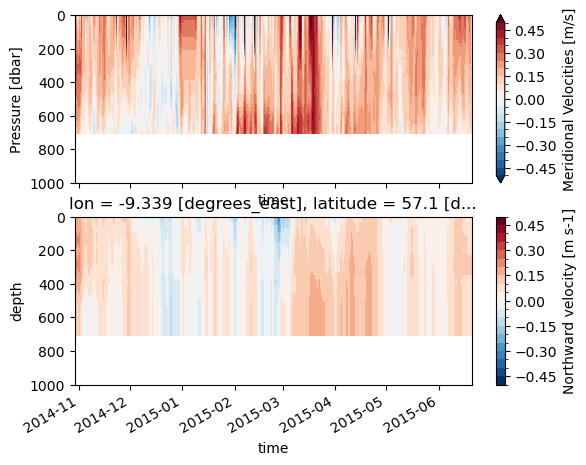

In [9]:
fig,axs = plt.subplots(2,1,sharex=True,sharey=True)
vmin,vmax,levs=-0.5,0.5,21
ax=axs[0]
ds_RTADCP.vcur.plot(x='time',ax=ax,ylim=[1000,0],cmap='RdBu_r',
                   vmin=vmin,vmax=vmax,levels=levs)
ax=axs[1]
v_GLO_RTADCP.plot(x='time',ax=ax,ylim=[1000,0],cmap='RdBu_r',
                 vmin=vmin,vmax=vmax,levels=levs)

In [10]:
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/filter_length # cut off frequency
with xr.set_options(keep_attrs=True):
    ds_RTADCP_lp = rtf.lazy_butter_lp_filter(ds_RTADCP.vcur.mean('depth'),lowcut,fs,dim='time')
    v_GLO_RTADCP_lp = rtf.lazy_butter_lp_filter(v_GLO_RTADCP.mean('depth'),lowcut,fs,dim='time')

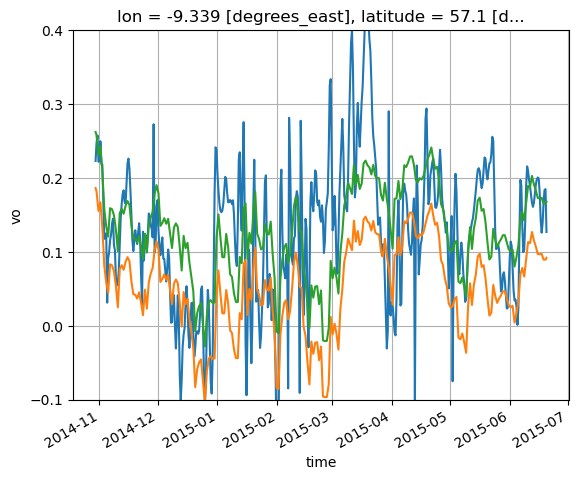

In [11]:
ds_RTADCP.vcur.mean('depth').plot()
v_GLO_RTADCP.mean('depth').plot()
(v_GLO_RTADCP.mean('depth')+corr_model).plot()
plt.ylim([-0.1,0.4])
plt.grid()

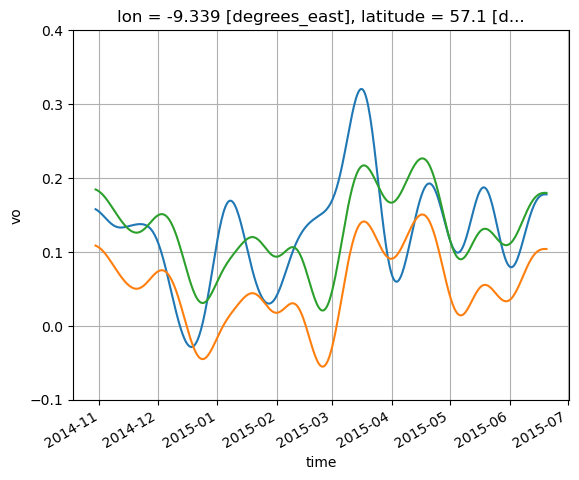

In [12]:
ds_RTADCP_lp.plot()
v_GLO_RTADCP_lp.plot()
(v_GLO_RTADCP_lp+corr_model).plot()
plt.ylim([-0.1,0.4])
plt.grid()

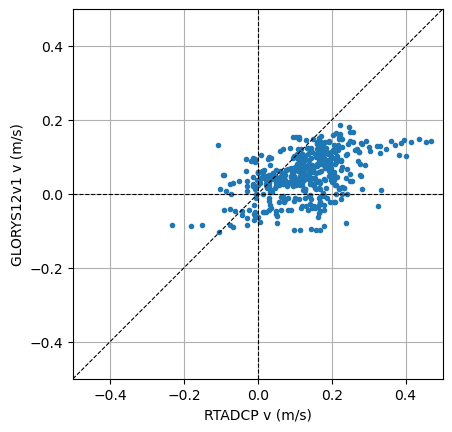

In [13]:
fig,axs=plt.subplots(1,1)
axs.plot(ds_RTADCP.vcur.mean('depth'),v_GLO_RTADCP.mean('depth'),'.')
axs.plot(np.arange(-7,11),np.arange(-7,11),color='k',lw=0.8,ls='--')
# axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
axs.set_xlabel('RTADCP v (m/s)')
axs.set_ylabel('GLORYS12v1 v (m/s)')
axs.set_ylim([-.5,.5])
axs.set_xlim([-.5,.5])
axs.set_aspect('equal', adjustable='box')
axs.grid()
axs.axvline(0,color='k',lw=0.8,ls='--')
axs.axhline(0,color='k',lw=0.8,ls='--')

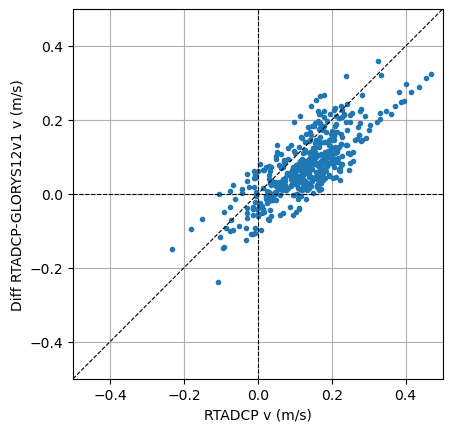

In [14]:
fig,axs=plt.subplots(1,1)
axs.plot(ds_RTADCP.vcur.mean('depth'),ds_RTADCP.vcur.mean('depth')-v_GLO_RTADCP.mean('depth'),'.')
axs.plot(np.arange(-7,11),np.arange(-7,11),color='k',lw=0.8,ls='--')
# axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
axs.set_xlabel('RTADCP v (m/s)')
axs.set_ylabel('Diff RTADCP-GLORYS12v1 v (m/s)')
axs.set_ylim([-.5,.5])
axs.set_xlim([-.5,.5])
axs.set_aspect('equal', adjustable='box')
axs.grid()
axs.axvline(0,color='k',lw=0.8,ls='--')
axs.axhline(0,color='k',lw=0.8,ls='--')

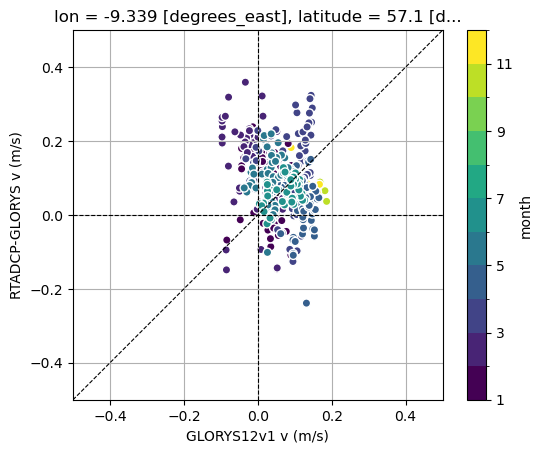

In [35]:
fig,axs=plt.subplots(1,1)
ax=axs
v_merge = xr.merge([ds_RTADCP.vcur.mean('depth').rename('v_RTADCP'),
                 v_GLO_RTADCP.mean('depth').rename('v_GLORYS')])
v_merge['v_diff'] = v_merge.v_RTADCP-v_merge.v_GLORYS
v_merge['month'] = v_merge.time.dt.month


v_merge.plot.scatter(x='v_GLORYS',y='v_diff',hue='month',
                    ax=ax,levels=12)
ax.plot(np.arange(-7,11),np.arange(-7,11),color='k',lw=0.8,ls='--')
# axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
ax.set_ylabel('RTADCP-GLORYS v (m/s)')
ax.set_xlabel('GLORYS12v1 v (m/s)')
ax.set_ylim([-.5,.5])
ax.set_xlim([-.5,.5])
ax.set_aspect('equal', adjustable='box')
ax.grid()
ax.axvline(0,color='k',lw=0.8,ls='--')
ax.axhline(0,color='k',lw=0.8,ls='--')

# Reconstruction
Idea: Use GLORYS v at RTADCP locations ($X$) to reproduce RTADCP v ($y$):
$$
X \alpha + \beta= y
$$


In [16]:
from sklearn.linear_model import LinearRegression
x = v_merge.v_GLORYS.values.reshape(-1, 1)
y = v_merge.v_RTADCP.values.reshape(-1, 1)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.2293846982662946
intercept: [0.08645903]
slope: [[0.7841664]]


In [17]:
v_merge['v_GLORYS_corr'] = ('time',model.predict(x).squeeze())
v_merge['v_GLORYS_const'] = v_merge.v_GLORYS+corr_model

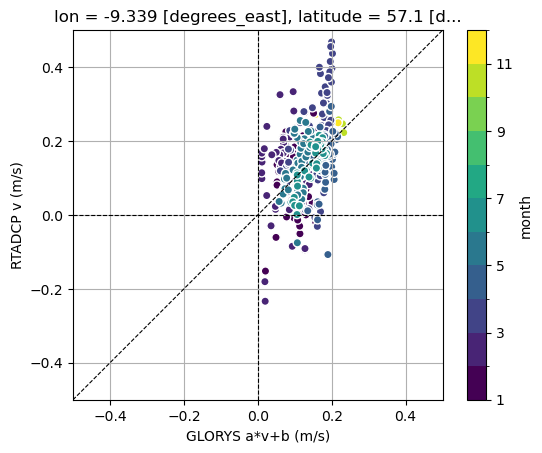

In [18]:
fig,axs=plt.subplots(1,1)
ax=axs
v_merge.plot.scatter(x='v_GLORYS_corr',y='v_RTADCP',hue='month',
                    ax=ax,levels=12)
ax.plot(np.arange(-7,11),np.arange(-7,11),color='k',lw=0.8,ls='--')
# axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
ax.set_ylabel('RTADCP v (m/s)')
ax.set_xlabel('GLORYS a*v+b (m/s)')
ax.set_ylim([-.5,.5])
ax.set_xlim([-.5,.5])
ax.set_aspect('equal', adjustable='box')
ax.grid()
ax.axvline(0,color='k',lw=0.8,ls='--')
ax.axhline(0,color='k',lw=0.8,ls='--')

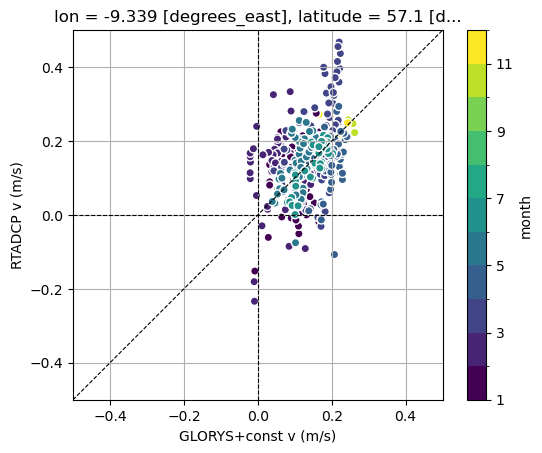

In [19]:
fig,axs=plt.subplots(1,1)
ax=axs
v_merge.plot.scatter(x='v_GLORYS_const',y='v_RTADCP',hue='month',
                    ax=ax,levels=12)
ax.plot(np.arange(-7,11),np.arange(-7,11),color='k',lw=0.8,ls='--')
# axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
ax.set_ylabel('RTADCP v (m/s)')
ax.set_xlabel('GLORYS+const v (m/s)')
ax.set_ylim([-.5,.5])
ax.set_xlim([-.5,.5])
ax.set_aspect('equal', adjustable='box')
ax.grid()
ax.axvline(0,color='k',lw=0.8,ls='--')
ax.axhline(0,color='k',lw=0.8,ls='--')

In [20]:
y = v_merge.v_diff.values.reshape(-1, 1)
x = v_merge.v_GLORYS.values.reshape(-1, 1)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
v_merge['alpha'] = ('time',model.predict(x).squeeze())
v_merge['v_GLORYS_alpha']= v_merge.alpha+v_merge.v_GLORYS

coefficient of determination: 0.02205281902544931
intercept: [0.08645903]
slope: [[-0.21583366]]


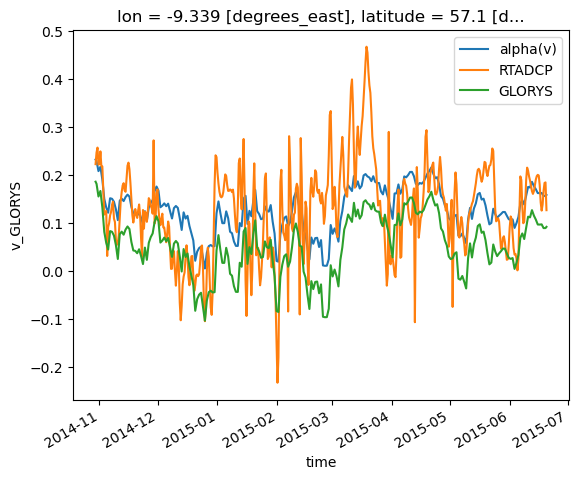

In [21]:
(v_merge.alpha+v_merge.v_GLORYS).plot(label='alpha(v)')
v_merge.v_RTADCP.plot(label='RTADCP')
v_merge.v_GLORYS.plot(label='GLORYS')
plt.legend()

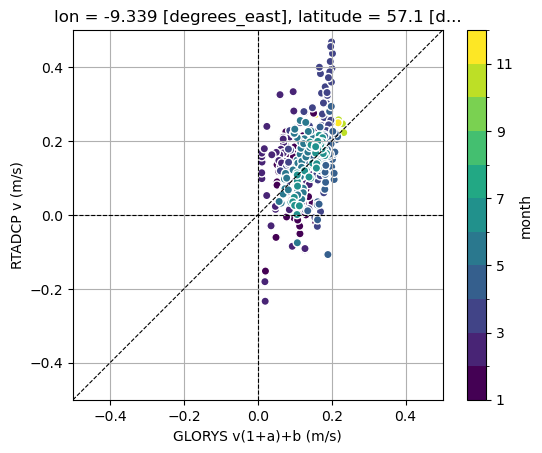

In [22]:
fig,axs=plt.subplots(1,1)
ax=axs
v_merge.plot.scatter(x='v_GLORYS_alpha',y='v_RTADCP',hue='month',
                    ax=ax,levels=12)
ax.plot(np.arange(-7,11),np.arange(-7,11),color='k',lw=0.8,ls='--')
# axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
ax.set_ylabel('RTADCP v (m/s)')
ax.set_xlabel('GLORYS v(1+a)+b (m/s)')
ax.set_ylim([-.5,.5])
ax.set_xlim([-.5,.5])
ax.set_aspect('equal', adjustable='box')
ax.grid()
ax.axvline(0,color='k',lw=0.8,ls='--')
ax.axhline(0,color='k',lw=0.8,ls='--')

In [23]:
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/filter_length # cut off frequency
with xr.set_options(keep_attrs=True):
    v_RTADCP_lp = rtf.lazy_butter_lp_filter(v_merge.v_RTADCP,lowcut,fs,dim='time')
    v_GLO_alpha_lp = rtf.lazy_butter_lp_filter(v_merge.v_GLORYS_alpha,lowcut,fs,dim='time')
    v_GLO_const_lp = rtf.lazy_butter_lp_filter(v_merge.v_GLORYS_const,lowcut,fs,dim='time')

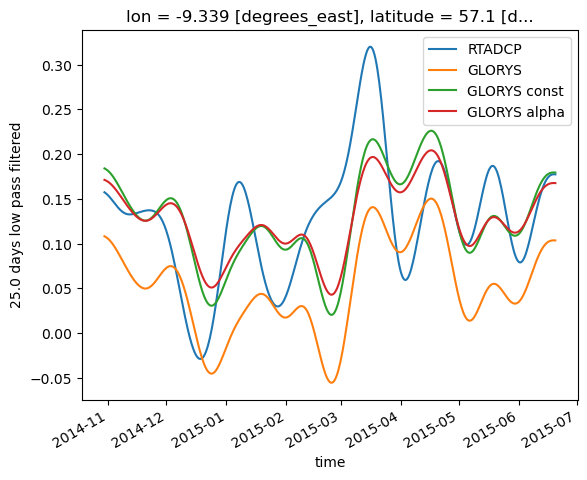

In [24]:
v_RTADCP_lp.plot(label='RTADCP')
v_GLO_RTADCP_lp.plot(label='GLORYS')
v_GLO_const_lp.plot(label='GLORYS const')
v_GLO_alpha_lp.plot(label='GLORYS alpha')
plt.legend()

In [32]:
y = v_RTADCP_lp.values.reshape(-1, 1)
x = v_GLO_RTADCP_lp.values.reshape(-1, 1)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
v_GLO_alpha2_lp = xr.DataArray(model.predict(x).squeeze(),coords={'time':v_merge.time})

coefficient of determination: 0.24627798625954023
intercept: [0.0917026]
slope: [[0.67647786]]


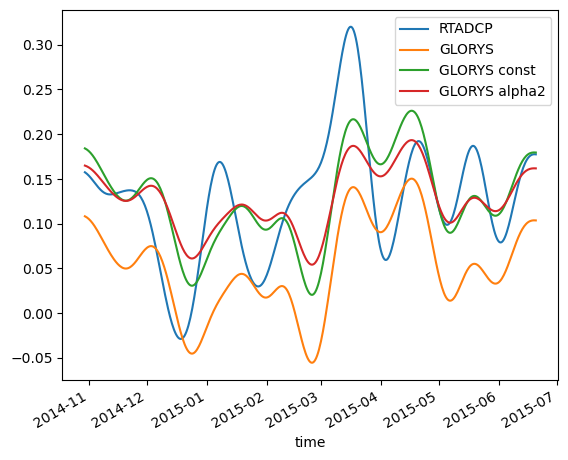

In [33]:
v_RTADCP_lp.plot(label='RTADCP')
v_GLO_RTADCP_lp.plot(label='GLORYS')
v_GLO_const_lp.plot(label='GLORYS const')
v_GLO_alpha2_lp.plot(label='GLORYS alpha2')
plt.legend()